In [1]:
!pip install fastprogress

In [2]:
import string
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from fastprogress import master_bar, progress_bar

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab/Naamkaran/data/fl_fn_train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Colab/Naamkaran/data/fl_fn_val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab/Naamkaran/data/fl_fn_test.csv")

In [4]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(291615, 2)
(182259, 2)
(182260, 2)


In [5]:
train_df.head()

,name_first,gender
0,Vashawdius,F
1,Kelinger,F
2,Odalilia,F
3,Dayzia,F
4,Mangal,M


## Create Vocab

In [6]:
vectorizer = CountVectorizer(analyzer='char', lowercase=False)
vectorizer.fit_transform(train_df['name_first'])
vocab = list(vectorizer.get_feature_names_out())
n_letters = len(vocab)
seq_len = train_df['name_first'].str.len().max()

print(seq_len)
print(n_letters)

27
55


In [8]:
import joblib

joblib.dump(vectorizer, "/content/drive/MyDrive/Colab/Naamkaran/names_vec.joblib", compress=3)  # compression is ON!

['/content/drive/MyDrive/Colab/Naamkaran/names_vec.joblib']

## Create Dataset

In [ ]:
all_letters = ''.join(vocab)
oob = n_letters + 1

class NamesDataset(Dataset):
    def __init__(self, names, genders):
        self.names = names
        self.genders = genders
        self.gender_to_idx = {'F': 0, 'M': 1}

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        name = self.names[index]
        gender = self.genders[index]

        input_tensor = torch.ones(seq_len) * oob
        for li, letter in enumerate(name[:-1]):
          input_tensor[li] = all_letters.find(letter)

        target_tensor = torch.ones(seq_len) * oob
        for li, letter in enumerate(name[1:]):
          target_tensor[li] = all_letters.find(letter)

        gender_tensor = torch.tensor(self.gender_to_idx[gender], dtype=torch.long)

        return input_tensor, gender_tensor, target_tensor

In [ ]:
# Create dataset and dataloader
batch_size = 64
train_dataset = NamesDataset(train_df['name_first'], train_df['gender'])
val_dataset = NamesDataset(val_df['name_first'], val_df['gender'])
test_dataset = NamesDataset(test_df['name_first'], test_df['gender'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=lambda x: x, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=lambda x: x, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=lambda x: x, num_workers=os.cpu_count())

In [ ]:
inp, gen, out = train_dataset[0]
print(inp, gen, out)

tensor([24., 29., 47., 36., 29., 51., 32., 37., 49., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.]) tensor(0) tensor([29., 47., 36., 29., 51., 32., 37., 49., 47., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.])


In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
  print(f"total records in single batch: {len(sample_batched)}")
  print(f"total tensors in single record: {len(sample_batched[0])}")
  print(f"input tensor shape: {sample_batched[0][0].shape}")
  print(f"gender tensor shape: {sample_batched[0][1].shape}")
  print(f"target tensor shape: {sample_batched[0][2].shape}")
  break


total records in single batch: 64
total tensors in single record: 3
input tensor shape: torch.Size([27])
gender tensor shape: torch.Size([])
target tensor shape: torch.Size([27])


# Define model

In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


class NameGenerator(nn.Module):
    def __init__(self, input_size, gender_size, hidden_size, output_size, n_layers=1):
        super(NameGenerator, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gender_embedding = nn.Embedding(gender_size, hidden_size)

        # LSTM now receives 2 * hidden_size because of concatenated embeddings
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, gender, hidden):
        name_embedded = self.embedding(input_seq)

        # Embed the gender and expand its dimensions to match the name_embedded tensor
        gender_embedded = self.gender_embedding(gender)
        gender_embedded = gender_embedded.unsqueeze(1).expand(-1, input_seq.size(1), -1)

        combined = torch.cat((name_embedded, gender_embedded), 2)

        output, hidden = self.lstm(combined, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))


# Hyperparameters
hidden_size = 100
n_layers = 1
learning_rate = 0.005
gender_size = 2

vocab_size = n_letters + 1 + 1 # vocab + oob + 1

# Initialize the model
model = NameGenerator(vocab_size, gender_size, hidden_size, vocab_size, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model.to(device)

Device: cuda:0


NameGenerator(
  (embedding): Embedding(57, 100)
  (gender_embedding): Embedding(2, 100)
  (lstm): LSTM(200, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=57, bias=True)
)

## Verify with sample data

In [ ]:
name = "Rogers"
gender_to_idx = {'F': 0, 'M': 1}

input_tensor = torch.ones(seq_len) * oob
for li, letter in enumerate(name[:-1]):
  input_tensor[li] = all_letters.find(letter)

gender_tensor = torch.tensor(gender_to_idx['M'], dtype=torch.long)

target_tensor = torch.ones(seq_len) * oob
for li, letter in enumerate(name[1:]):
  target_tensor[li] = all_letters.find(letter)

hidden = model.init_hidden(1, device)

print(input_tensor.shape)
print(target_tensor.shape)

input_tensor = input_tensor.unsqueeze(0).to(torch.long)
gender_tensor = gender_tensor.unsqueeze(0).to(device)
target_tensor = target_tensor.to(torch.long)

output, _ = model(input_tensor.to(device), gender_tensor, hidden)

print(output.shape)

torch.Size([27])
torch.Size([27])
torch.Size([1, 27, 57])


## Train

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6ee1124040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6ee1124040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

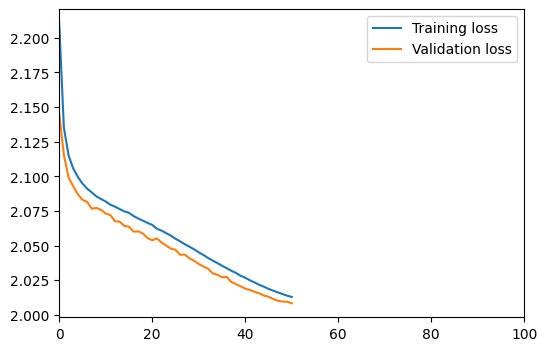

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 2.145379).  Saving model ...


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (2.145379 --> 2.115407).  Saving model ...
Validation loss decreased (2.115407 --> 2.099243).  Saving model ...
Validation loss decreased (2.099243 --> 2.092792).  Saving model ...
Validation loss decreased (2.092792 --> 2.086963).  Saving model ...
Validation loss decreased (2.086963 --> 2.083040).  Saving model ...
Validation loss decreased (2.083040 --> 2.081504).  Saving model ...
Validation loss decreased (2.081504 --> 2.076537).  Saving model ...
Validation loss decreased (2.076537 --> 2.075772).  Saving model ...
Validation loss decreased (2.075772 --> 2.073104).  Saving model ...
Validation loss decreased (2.073104 --> 2.071998).  Saving model ...
Validation loss decreased (2.071998 --> 2.067564).  Saving model ...
Validation loss decreased (2.067564 --> 2.067199).  Saving model ...
Validation loss decreased (2.067199 --> 2.064147).  Saving model ...
Validation loss decreased (2.064147 --> 2.063602).  Saving model ...
Validation loss decreased (2.06360

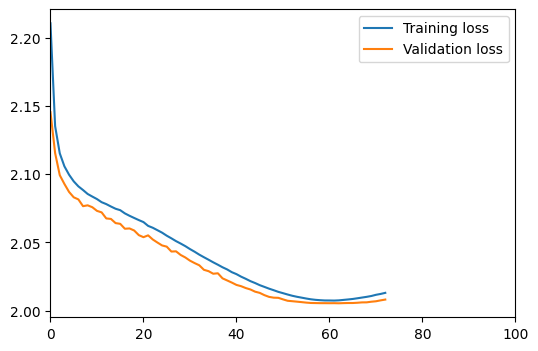

Validation loss decreased (2.008274 --> 2.007244).  Saving model ...
Validation loss decreased (2.007244 --> 2.006930).  Saving model ...
Validation loss decreased (2.006930 --> 2.006599).  Saving model ...
Validation loss decreased (2.006599 --> 2.006257).  Saving model ...
Validation loss decreased (2.006257 --> 2.005901).  Saving model ...
Validation loss decreased (2.005901 --> 2.005633).  Saving model ...
Validation loss decreased (2.005633 --> 2.005565).  Saving model ...
Validation loss decreased (2.005565 --> 2.005497).  Saving model ...
Validation loss decreased (2.005497 --> 2.005491).  Saving model ...
Validation loss decreased (2.005491 --> 2.005460).  Saving model ...
Validation loss decreased (2.005460 --> 2.005409).  Saving model ...


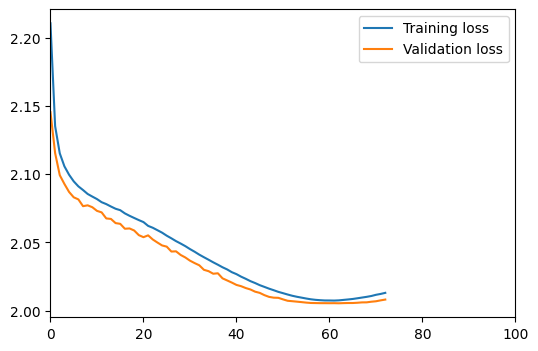

In [ ]:
epochs = 100
lr = 0.005

criterion = nn.CrossEntropyLoss(ignore_index=oob)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)

early_stopper = EarlyStopper(patience=10)

mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']


x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 1000

for epoch in mb:
  x.append(epoch)
  total_loss = torch.Tensor([0.0]).to(device)
  model.train()
  for batch in progress_bar(train_loader, parent=mb):
    model.zero_grad()
    input_batch = []
    gender_batch = []
    target_batch = []

    # Prepare the inputs and targets as batch tensors
    for input_tensor, gender_tensor, target_tensor in batch:
        input_batch.append(input_tensor)
        gender_batch.append(gender_tensor)
        target_batch.append(target_tensor)

    input_batch = torch.stack(input_batch).to(torch.long).to(device)
    gender_batch = torch.stack(gender_batch).to(torch.long).to(device)
    target_batch = torch.stack(target_batch).to(torch.long).to(device)

    # Initialize hidden state and zero the gradients
    hidden = model.init_hidden(batch_size, device)
    optimizer.zero_grad()

    # Forward pass
    output, _ = model(input_batch, gender_batch, hidden)

    # Reshape the output to (batch_size * seq_len, vocab_size)
    output_reshaped = output.view(-1, vocab_size)

    # Reshape the target to (batch_size * seq_len)
    target_reshaped = target_batch.view(-1)

    # Compute the loss
    loss = criterion(output_reshaped, target_reshaped)

    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  # decay lr
  scheduler.step()
  mean = total_loss / len(train_loader)
  training_losses.append(mean.cpu())

  # Validation
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_loader, parent=mb):
      input_batch = []
      gender_batch = []
      target_batch = []
      # Prepare the inputs and targets as batch tensors
      for input_tensor, gender_tensor, target_tensor in batch:
          input_batch.append(input_tensor)
          gender_batch.append(gender_tensor)
          target_batch.append(target_tensor)

      input_batch = torch.stack(input_batch).to(torch.long).to(device)
      gender_batch = torch.stack(gender_batch).to(torch.long).to(device)
      target_batch = torch.stack(target_batch).to(torch.long).to(device)

      # Initialize hidden state and zero the gradients
      hidden = model.init_hidden(batch_size, device)

      output, _ = model(input_batch, gender_batch, hidden)
      output_reshaped = output.view(-1, vocab_size)
      target_reshaped = target_batch.view(-1)
      loss = criterion(output_reshaped, target_reshaped)
      validation_loss += loss.item()

  val_mean = validation_loss / len(val_loader)
  #val_mean = validation_loss / till_bathc
  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/Naamkaran/naamkaran.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):
      break

## Save Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/Naamkaran/naamkaran_after_train.pt')

Text(0, 0.5, 'loss')

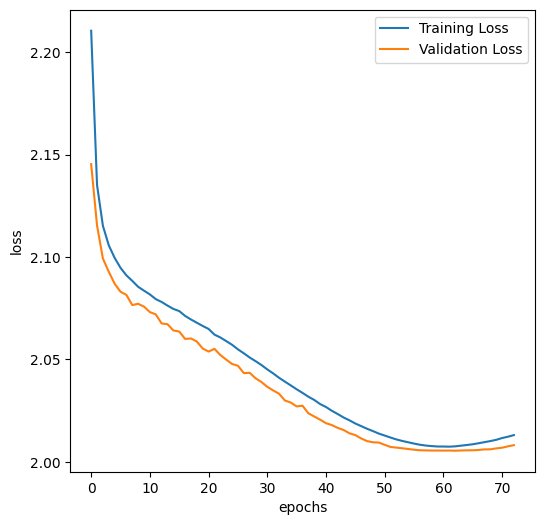

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, training_losses, validation_losses)
ax.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("epochs")
plt.ylabel("loss")

In [ ]:
# last epoch losses
print(training_losses[-1])
print(validation_losses[-1])

tensor([2.0130])
tensor([2.0081])


## Load model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/Naamkaran/naamkaran.pt'))

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=oob)

## Validate on test dataset

In [ ]:
# Trackers for the metrics
total_characters = 0
correct_characters = 0
correct_sequences = 0

model.eval()

for batch in test_loader:
    input_batch = []
    gender_batch = []
    target_batch = []

    # Prepare the inputs and targets as batch tensors
    for input_tensor, gender_tensor, target_tensor in batch:
        input_batch.append(input_tensor)
        gender_batch.append(gender_tensor)
        target_batch.append(target_tensor)

    input_batch = torch.stack(input_batch).to(torch.long).to(device)
    gender_batch = torch.stack(gender_batch).to(torch.long).to(device)
    target_batch = torch.stack(target_batch).to(torch.long).to(device)

    # Initialize hidden state
    hidden = model.init_hidden(batch_size, device)

    # Forward pass
    with torch.no_grad():
        output, _ = model(input_batch, gender_batch, hidden)

    # Get the predicted character indices
    predictions = torch.argmax(output, dim=-1)

    # Update the character-level accuracy
    correct_characters += (predictions == target_batch).sum().item()
    total_characters += target_batch.nelement()

    # Update the sequence-level accuracy
    correct_sequences += (predictions == target_batch).all(dim=-1).sum().item()

# Compute the final metrics
character_accuracy = correct_characters / total_characters
sequence_accuracy = correct_sequences / len(test_loader.dataset)

print(f"Character-Level Accuracy: {character_accuracy * 100:.2f}%")
print(f"Sequence-Level Accuracy: {sequence_accuracy * 100:.2f}%")

Character-Level Accuracy: 8.61%
Sequence-Level Accuracy: 0.00%


## Inference

In [ ]:
from ast import While

gender_to_idx = {'F': 0, 'M': 1}

def generate_name(start_letter, end_letter=None, gender='M', how_many=1, max_length=20, temperature=1.0):
    generated_names = []

    while how_many:
      # Convert start_letter to a tensor
      input_tensor = torch.full((1,), all_letters.find(start_letter), dtype=torch.long).to(device)

      # Initialize hidden state
      hidden = model.init_hidden(1, device)

      # Convert gender to a tensor
      gender_tensor = torch.tensor(gender_to_idx[gender], dtype=torch.long).unsqueeze(0).to(device)

      # Initialize the generated name with the start letter
      generated_name = start_letter
      # Repeatedly predict the next character
      for _ in range(max_length - 1):
          # Forward pass
          with torch.no_grad():
              output, hidden = model(input_tensor.unsqueeze(0), gender_tensor, hidden)
              output_dist = torch.softmax(output[0] / temperature, dim=-1)
              top_idx = torch.multinomial(output_dist, 1).item()

          # Check if the index is out-of-bounds, which might signal the end of the name
          if top_idx == oob or top_idx == 0:
              break

          # Append the predicted letter to the generated name
          next_letter = all_letters[top_idx]
          generated_name += next_letter

          # Update the input tensor for the next iteration
          input_tensor = torch.tensor([top_idx], dtype=torch.long).to(device)

      if end_letter is None or generated_name[-1] == end_letter and generated_name not in generated_names:
        generated_names.append(generated_name)
        how_many -= 1

    return generated_names

In [ ]:
start_letter = "J"
end_letter = "n"
gender = 'M'

generated_names = generate_name(start_letter, end_letter, gender, how_many=20, max_length=5, temperature=0.5)
print(f"Generated names starting with '{start_letter}':")
for name in generated_names:
  print(name)

Generated names starting with 'J':
Jan
Jean
John
Joann
Jinan
Joman
Jon
Jasan
Jaron
Juan
Jeran
Javon
Jivan
Jason
Jamon
Jian
Jahon
Johan
Jaman
Jun


In [ ]:
start_letter = "A"
end_letter = "e"
gender = 'F'

generated_names = generate_name(start_letter, end_letter, gender, how_many=30, max_length=5, temperature=0.5)
print(f"Generated names starting with '{start_letter}':")
for name in generated_names:
  print(name)

Generated names starting with 'A':
Anne
Anale
Andre
Amare
Alise
Alice
Annie
Annte
Adrye
Anune
Audre
Ashle
Anade
Annye
Allie
Anire
Ambre
Angle
Altre
Anare
Aline
Angye
Adele
Antre
Anabe
Arine
Arlie
Adane
Arale
Alece
